# 14. 범주형 데이터 인코딩
- 모델링의 구현에는 범주형 변수에 대한 수치형 변환이 필요


<br>

## 14.01. 인코딩
- 트리나 규칙을 기반으로 하는 모델과 같은 소수의 모델은 기본적으로 범주형 데이터를 처리할 수 있으며, 이러한 종류의 기능을 인코딩하거나 변환할 필요가 없음. 

<br>

- 기본적으로 범주형 변수를 처리할 수 있는 이러한 모델은, 수치형 변수도 처리할 수 있으므로 이러한 변수의 변환이나 인코딩을 선택적으로 만들 수 있음 
    
    - **변환되지 않은 범주형 변수가 있는 벤치마크 데이터 세트를 사용하여, 동일한 기능에 대해 변환된 더미 변수와 비교하는 하였을 때,** 
        
        **더미 인코딩을 사용하면 일반적으로 모델 성능이 향상되지는 않지만 모델을 훈련하는 데 더 많은 시간이 필요**

<br>

## 14.02. 순서형 변수 인코딩
- **"낮음", "중간", "높음"과 같이 순서가 지정된 순서형 변수에 대한 인코딩 전략은, 다항식 기반의 새로운 수치형 변수를 만드는 것**

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:encoding-ordered-table"></span>
</caption>
<thead>
<tr>
<th style="text-align:left;">
Raw Data
</th>
<th style="text-align:right;">
Linear
</th>
<th style="text-align:right;">
Quadratic
</th>
<th style="text-align:right;">
Cubic
</th>
<th style="text-align:right;">
Quartic
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
none
</td>
<td style="text-align:right;">
-0.63
</td>
<td style="text-align:right;">
0.53
</td>
<td style="text-align:right;">
-0.32
</td>
<td style="text-align:right;">
0.12
</td>
</tr>
<tr>
<td style="text-align:left;">
a little
</td>
<td style="text-align:right;">
-0.32
</td>
<td style="text-align:right;">
-0.27
</td>
<td style="text-align:right;">
0.63
</td>
<td style="text-align:right;">
-0.48
</td>
</tr>
<tr>
<td style="text-align:left;">
some
</td>
<td style="text-align:right;">
0.00
</td>
<td style="text-align:right;">
-0.53
</td>
<td style="text-align:right;">
0.00
</td>
<td style="text-align:right;">
0.72
</td>
</tr>
<tr>
<td style="text-align:left;">
a bunch
</td>
<td style="text-align:right;">
0.32
</td>
<td style="text-align:right;">
-0.27
</td>
<td style="text-align:right;">
-0.63
</td>
<td style="text-align:right;">
-0.48
</td>
</tr>
<tr>
<td style="text-align:left;">
copious amounts
</td>
<td style="text-align:right;">
0.63
</td>
<td style="text-align:right;">
0.53
</td>
<td style="text-align:right;">
0.32
</td>
<td style="text-align:right;">
0.12
</td>
</tr>
</tbody>
</table>

- **혹은 순서형 변수를 일반 범주형 변수로 변환 하거나, (`step_unorder()`)**
    
    **순서형 변수의 각 등급을 특정 숫자로 치환하여 수치형 변수로 변환 (`step_ordinalscore()`)**

<br>

## 14.03. 인코딩 변수 활용
- 더미 또는 명목형 변수보다 더 복잡한 인코딩을 위한 여러 옵션이 존재. 
* **효과(effect) 또는 가능도(likelihood) 인코딩 이라는 방법은 원래 범주형 변수를 해당 데이터의 효과를 측정하는 단일 숫자 열로 대체(Micci-Barreca 2001 ; Zumel 및 Mount 2019)**
    - 효과 인코딩은 범주형 변수의 수준이 많을 때 잘 작동
    

In [2]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

In [4]:
ames <- ames %>% mutate(Sale_Price = log10(Sale_Price))
set.seed(20221010)
ames_split <- initial_split(ames, prop = 0.8, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test <- testing(ames_split)

<br>

### 일반 효과 인코딩

#### `step_lencode()`
- 범주형 변수의 각 수준을, 범주별 평균 혹은 중앙값으로 대체

- `Neighborhood` 별 `Sale_Price`의 평균과 95% 신뢰구간

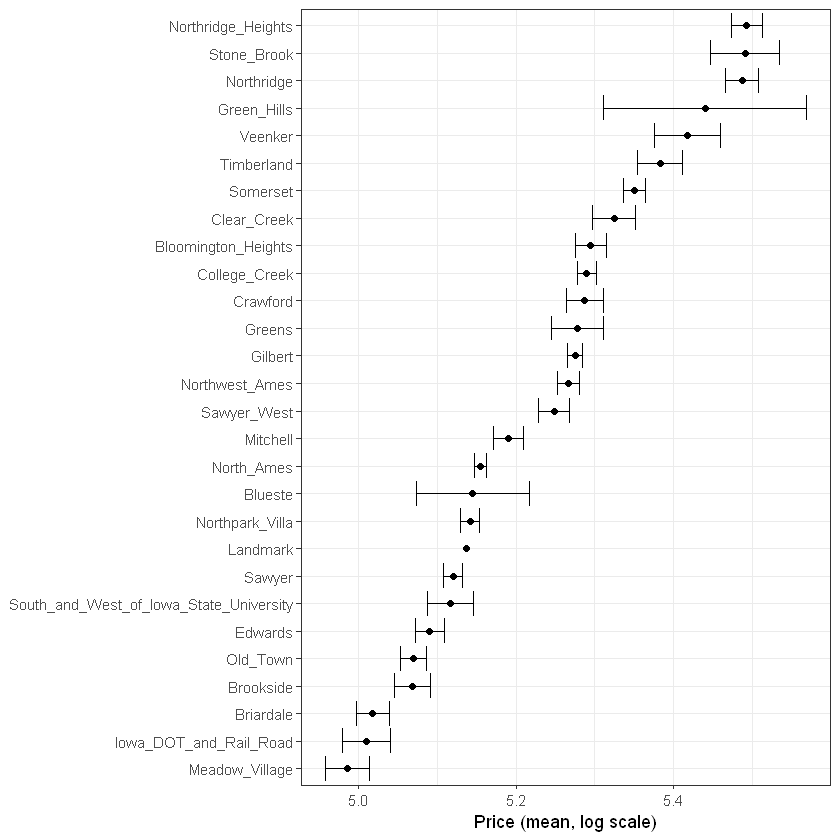

In [6]:
ames_train %>%
    group_by(Neighborhood) %>%
    summarize(mean = mean(Sale_Price),
            std_err = sd(Sale_Price) / sqrt(length(Sale_Price))) %>% 
    ggplot(aes(y = reorder(Neighborhood, mean), x = mean)) + 
    geom_point() +
    geom_errorbar(aes(xmin = mean - 1.64 * std_err, xmax = mean + 1.64 * std_err)) +
    labs(y = NULL, x = "Price (mean, log scale)")

<br>

### GLM 효과 인코딩
#### `step_lencode_glm()` : GLM 모델을 통해 얻은 계수를 범주형 변수의 각 수준을 인코딩하는 값으로 대체
- 반응변수와 설명변수 간의 관계를 나타내는 **일반화 선형 모델**을 적합하여 수행

- 타겟 인코딩의 주의점 : 범주형 변수에 대한 타겟 인코딩은, **실제 모델 내에 인코딩을 위한 미니모델을 새성하는 것이므로 과적합의 가능성이 존재**

In [7]:
library(embed)

In [8]:
ames_glm <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
                   Latitude + Longitude, data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_lencode_glm(Neighborhood, outcome = vars(Sale_Price)) %>%
    step_dummy(all_nominal_predictors()) %>% 
    step_interact(~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
    step_ns(Latitude, Longitude, deg_free = 20)

ames_glm



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Log transformation on: Gr_Liv_Area

• Linear embedding for factors via GLM for: Neighborhood

• Dummy variables from: all_nominal_predictors()

• Interactions with: Gr_Liv_Area:starts_with("Bldg_Type_")

• Natural splines on: Latitude and Longitude



In [23]:
glm_estimates <- prep(ames_glm) %>%
    tidy(number = 2)

In [55]:
glm_estimates %>%
    filter(level == "..new")

level,value,terms,id
<chr>,<dbl>,<chr>,<chr>
..new,5.233151,Neighborhood,lencode_glm_jcstX


<br>

### 부분 풀링 효과 인코딩
- **범주가 많을수록 범주형 변수의 범주별 불균형이 존재할 가능성이 높음**
    
    $\rightarrow$ **부분 풀링을 사용하여, 표본 크기가 작은 범주는 전체 평균 효과 값으로 대체**

<br>

- 각 수준의 효과는 혼합 또는 계층적 GLM모델을 사용하여 추정

<br>

#### `step_lencode_mixed()`

In [56]:
ames_mixed <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
                     Latitude + Longitude, data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_lencode_mixed(Neighborhood, outcome = vars(Sale_Price)) %>%
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
    step_ns(Latitude, Longitude, deg_free = 20)

ames_mixed



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Log transformation on: Gr_Liv_Area

• Linear embedding for factors via mixed effects for: Neighborhood

• Dummy variables from: all_nominal_predictors()

• Interactions with: Gr_Liv_Area:starts_with("Bldg_Type_")

• Natural splines on: Latitude and Longitude



In [58]:
mixed_estimates <- prep(ames_mixed) %>%
    tidy(number = 2)

<br>

#### 풀링하지 않은 효과 인코딩 (`step_lencode_glm`)과의 비교
- 풀링하지 않은 인코딩 결과와 비교할 때, 대부분의 효과 추정치는 거의 동일하지만, 
    
    빈도가 가장 작은 범주들은 평균 효과값으로 대체되었기에, 동일하지 않음

Joining with `by = join_by(level)`
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


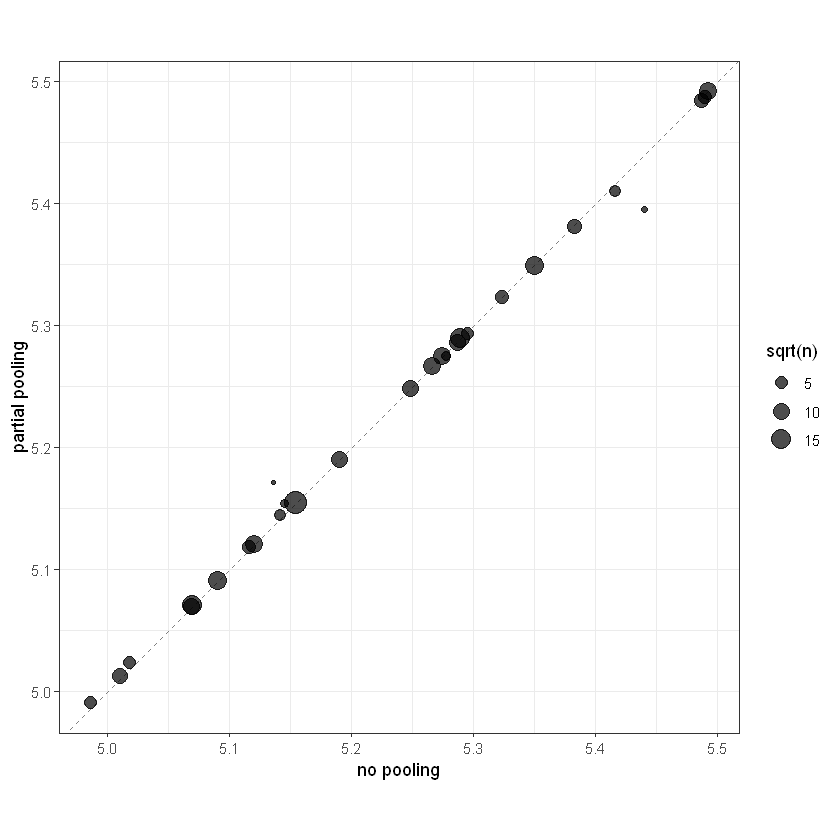

In [61]:
glm_estimates %>%
    rename(`no pooling` = value) %>%
    left_join(
        mixed_estimates %>%
            rename(`partial pooling` = value), by = "level"
    ) %>%
    left_join(
        ames_train %>% 
            count(Neighborhood) %>% 
            mutate(level = as.character(Neighborhood))
    ) %>%
    ggplot(aes(`no pooling`, `partial pooling`, size = sqrt(n))) +
    geom_abline(color = "gray50", lty = 2) +
    geom_point(alpha = 0.7) +
    coord_fixed()

<br>

## 14.04. 변수 해싱
- 해싱 함수는 가변 크기의 입력을 가져와 이를 고정 크기의 출력에 매핑되며, 일반적으로 암호화 및 데이터베이스에 사용
- 기능 해싱에서 가능한 해시 수는 하이퍼파라미터이며 모델 개발자가 정수 해시의 모듈로 계산을 통해 설정


<br>

### 해싱
#### `rlang::hash()` : 128비트 해시를 생성 ($2^{128}$의 가능 해시 값이 존재)
(높은 카디널리티 변수(다양한 범주의 변수)에는 유용하지 않은 수준)


<br>

- 16개의 가능한 해시 값


In [70]:
library(rlang)

In [71]:
ames_hashed <- ames_train %>%
    mutate(Hash = map_chr(Neighborhood, hash))

이제 원본 데이터의 28개 지역이나 엄청나게 많은 수의 원본 해시 대신 16개의 해시 값이 있습니다. 이 방법은 매우 빠르고 메모리 효율적이며 가능한 범주 수가 많을 때 좋은 전략

In [79]:
ames_hashed %>%
    mutate(Hash = strtoi(substr(Hash, 26, 32), base = 16L),  # R이 처리할 수 있는 정수에 대해 더 작은 해시를 생성
           Hash = Hash %% 16) %>%
    select(Neighborhood, Hash) %>% head

Neighborhood,Hash
<fct>,<dbl>
North_Ames,9
North_Ames,9
North_Ames,9
Briardale,0
Northpark_Villa,4
Northpark_Villa,4


- 원본 데이터의 28개의 범주와 많은 수의 원본 해시 대신, 16개의 해시 값으로 축소
    
    $\rightarrow$ 빠르고 메모리 효율적이며 가능한 범주 수가 많을 때 좋은 전략

In [86]:
ames_hashed %>%
    mutate(Hash = strtoi(substr(Hash, 26, 32), base = 16L),  # R이 처리할 수 있는 정수에 대해 더 작은 해시를 생성
           Hash = Hash %% 16) %>%
    select(Hash) %>% distinct

Hash
<dbl>
9
0
4
8
7
14
2
10
15


<br>

#### 충돌 
- **충돌 (collision, aliasing) : 서로 다른 범주 값에 동일한 해시값이 매핑 됨**  
    
    $\rightarrow$ **원본 데이터에는 28개의 범주가 있지만, 해싱을 통해 16개의 값으로 변환**

<br>

#### 변수 해싱의 고려사항
-  **해시 함수는 되돌릴 수 없으므로 기능 해싱을 직접 해석할 수 없으며, 해시 값에서 입력 범주 수준이 무엇인지 또는 충돌이 발생했는지 확인할 수 없음**

- **해시 값의 수는 하이퍼파라미터이므로, 특정 모델링 접근 방식에 가장 적합한 값을 결정하려면 여러 값을 시도해야 함**
    - **해시 값 수가 적을수록 충돌이 더 많이 발생하지만, 숫자가 높다고 해서 원래의 높은 카디널리티 변수에 비해 개선되지 않을 수도 있음**

- **변수 해싱은 미리 결정된 더미 변수에 의존하지 않기 때문에, 예측 시 새로운 범주 수준을 처리할 수 있음**


<br>

#### `step_dummy_hash()` 

In [87]:
library(textrecipes)

In [88]:
ames_hash <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
                    Latitude + Longitude, data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_dummy_hash(Neighborhood, signed = FALSE, num_terms = 16L) %>%
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
    step_ns(Latitude, Longitude, deg_free = 20)

In [89]:
ames_hash



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Log transformation on: Gr_Liv_Area

• Feature hashing with: Neighborhood

• Dummy variables from: all_nominal_predictors()

• Interactions with: Gr_Liv_Area:starts_with("Bldg_Type_")

• Natural splines on: Latitude and Longitude

